### 🚀 For an interactive experience, head over to our [demo platform](https://var.vision/demo) and dive right in! 🌟

In [3]:
################## 1. Download checkpoints and build models
import os
if os.path.exists('/content/VAR'): os.chdir('/content/VAR')
import os.path as osp
import torch, torchvision
import random
import numpy as np
import PIL.Image as PImage, PIL.ImageDraw as PImageDraw
setattr(torch.nn.Linear, 'reset_parameters', lambda self: None)     # disable default parameter init for faster speed
setattr(torch.nn.LayerNorm, 'reset_parameters', lambda self: None)  # disable default parameter init for faster speed
from models import VQVAE, build_vae_var


/Users/angelaqu/miniconda3/envs/10707-hw4/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/angelaqu/miniconda3/envs/10707-hw4/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <61623A3D-DA3C-3AAD-B2F0-D363151DDB3F> /Users/angelaqu/miniconda3/envs/10707-hw4/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <3FE16EFD-B5EE-33D2-A4C8-2BD93F2AA7BA> /Users/angelaqu/miniconda3/envs/10707-hw4/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")
/Users/angelaqu/miniconda3/envs/10707-hw4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
################## 1. Download checkpoints and build models
import os
if os.path.exists('/content/VAR'): os.chdir('/content/VAR')
import os.path as osp
import torch, torchvision
import random
import numpy as np
import PIL.Image as PImage, PIL.ImageDraw as PImageDraw
setattr(torch.nn.Linear, 'reset_parameters', lambda self: None)     # disable default parameter init for faster speed
setattr(torch.nn.LayerNorm, 'reset_parameters', lambda self: None)  # disable default parameter init for faster speed
from models import VQVAE, build_vae_var

# we recommend using imagenet-512-d36 model to do the in-painting & out-painting & class-condition editing task
MODEL_DEPTH = 36    # TODO: =====> please specify MODEL_DEPTH <=====

assert MODEL_DEPTH in {16, 20, 24, 30, 36}


# download checkpoint
hf_home = 'https://huggingface.co/FoundationVision/var/resolve/main'
vae_ckpt, var_ckpt = 'vae_ch160v4096z32.pth', f'var_d{MODEL_DEPTH}.pth'
if not osp.exists(vae_ckpt): os.system(f'wget {hf_home}/{vae_ckpt}')
if not osp.exists(var_ckpt): os.system(f'wget {hf_home}/{var_ckpt}')

# build vae, var
FOR_512_px = MODEL_DEPTH == 36
if FOR_512_px:
    patch_nums = (1, 2, 3, 4, 6, 9, 13, 18, 24, 32)
else:
    patch_nums = (1, 2, 3, 4, 5, 6, 8, 10, 13, 16)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
vae, var = build_vae_var(
    V=4096, Cvae=32, ch=160, share_quant_resi=4,    # hard-coded VQVAE hyperparameters
    device=device, patch_nums=patch_nums,
    num_classes=1000, depth=MODEL_DEPTH, shared_aln=FOR_512_px,
)

# load checkpoints
vae.load_state_dict(torch.load(vae_ckpt, map_location='cpu'), strict=True)
var.load_state_dict(torch.load(var_ckpt, map_location='cpu'), strict=True)
vae.eval(), var.eval()
for p in vae.parameters(): p.requires_grad_(False)
for p in var.parameters(): p.requires_grad_(False)
print(f'preparation finished.')


[constructor]  ==== flash_if_available=True (0/36), fused_if_available=True (fusing_add_ln=0/36, fusing_mlp=0/36) ==== 
    [VAR config ] embed_dim=2304, num_heads=36, depth=36, mlp_ratio=4.0
    [drop ratios ] drop_rate=0.0, attn_drop_rate=0.0, drop_path_rate=0.15 (tensor([0.0000, 0.0043, 0.0086, 0.0129, 0.0171, 0.0214, 0.0257, 0.0300, 0.0343,
        0.0386, 0.0429, 0.0471, 0.0514, 0.0557, 0.0600, 0.0643, 0.0686, 0.0729,
        0.0771, 0.0814, 0.0857, 0.0900, 0.0943, 0.0986, 0.1029, 0.1071, 0.1114,
        0.1157, 0.1200, 0.1243, 0.1286, 0.1329, 0.1371, 0.1414, 0.1457, 0.1500]))

[init_weights] VAR with init_std=0.0120281
preparation finished.


In [28]:
################## 2. Define some helper functions for zero-shot editing

from typing import List, Optional, Union

import torch
import torch.nn.functional as F
from models.var import AdaLNSelfAttn, sample_with_top_k_top_p_, gumbel_softmax_with_rng


def get_edit_mask(patch_nums: List[int], y0: float, x0: float, y1: float, x1: float, device, inpainting: bool = True) -> torch.Tensor:
    ph, pw = patch_nums[-1], patch_nums[-1]
    edit_mask = torch.zeros(ph, pw, device=device)
    edit_mask[round(y0 * ph):round(y1 * ph), round(x0 * pw):round(x1 * pw)] = 1 # outpainting mode: center would be gt
    if inpainting:
        edit_mask = 1 - edit_mask   # inpainting mode: center would be model pred
    return edit_mask    # a binary mask, 1 for keeping the tokens of the image to be edited; 0 for generating new tokens (by VAR)


# overwrite the function of 'VAR::autoregressive_infer_cfg'
def autoregressive_infer_cfg_with_mask(
    self, B: int, label_B: Optional[Union[int, torch.LongTensor]],
    g_seed: Optional[int] = None, cfg=1.5, top_k=0, top_p=0.0,
    more_smooth=False,
    input_img_tokens: Optional[List[torch.Tensor]] = None, edit_mask: Optional[torch.Tensor] = None,
) -> torch.Tensor:   # returns reconstructed image (B, 3, H, W) in [0, 1]
    """
    only used for inference, on autoregressive mode
    :param B: batch size
    :param label_B: imagenet label; if None, randomly sampled
    :param g_seed: random seed
    :param cfg: classifier-free guidance ratio
    :param top_k: top-k sampling
    :param top_p: top-p sampling
    :param more_smooth: smoothing the pred using gumbel softmax; only used in visualization, not used in FID/IS benchmarking
    :param input_img_tokens: (optional, only for zero-shot edit tasks) tokens of the image to be edited
    :param edit_mask: (optional, only for zero-shot edit tasks) binary mask, 1 for keeping given tokens; 0 for generating new tokens
    :return: if returns_vemb: list of embedding h_BChw := vae_embed(idx_Bl), else: list of idx_Bl
    """
    if g_seed is None: rng = None
    else: self.rng.manual_seed(g_seed); rng = self.rng

    if label_B is None:
        label_B = torch.multinomial(self.uniform_prob, num_samples=B, replacement=True, generator=rng).reshape(B)
    elif isinstance(label_B, int):
        label_B = torch.full((B,), fill_value=self.num_classes if label_B < 0 else label_B, device=self.lvl_1L.device)

    sos = cond_BD = self.class_emb(torch.cat((label_B, torch.full_like(label_B, fill_value=self.num_classes)), dim=0))

    lvl_pos = self.lvl_embed(self.lvl_1L) + self.pos_1LC
    next_token_map = sos.unsqueeze(1).expand(2 * B, self.first_l, -1) + self.pos_start.expand(2 * B, self.first_l, -1) + lvl_pos[:, :self.first_l]

    cur_L = 0
    f_hat = sos.new_zeros(B, self.Cvae, self.patch_nums[-1], self.patch_nums[-1])

    for b in self.blocks: b.attn.kv_caching(True)
    for si, pn in enumerate(self.patch_nums):   # si: i-th segment
        ratio = si / self.num_stages_minus_1
        # last_L = cur_L
        cur_L += pn*pn
        # assert self.attn_bias_for_masking[:, :, last_L:cur_L, :cur_L].sum() == 0, f'AR with {(self.attn_bias_for_masking[:, :, last_L:cur_L, :cur_L] != 0).sum()} / {self.attn_bias_for_masking[:, :, last_L:cur_L, :cur_L].numel()} mask item'
        cond_BD_or_gss = self.shared_ada_lin(cond_BD)
        x = next_token_map
        AdaLNSelfAttn.forward
        for b in self.blocks:
            x = b(x=x, cond_BD=cond_BD_or_gss, attn_bias=None)
        logits_BlV = self.get_logits(x, cond_BD)

        t = cfg * ratio
        logits_BlV = (1+t) * logits_BlV[:B] - t * logits_BlV[B:]

        idx_Bl = sample_with_top_k_top_p_(logits_BlV, rng=rng, top_k=top_k, top_p=top_p, num_samples=1)[:, :, 0]
        if not more_smooth: # this is the default case
            h_BChw = self.vae_quant_proxy[0].embedding(idx_Bl)   # B, l, Cvae
        else:   # not used when evaluating FID/IS/Precision/Recall
            gum_t = max(0.27 * (1 - ratio * 0.95), 0.005)   # refer to mask-git
            h_BChw = gumbel_softmax_with_rng(logits_BlV.mul(1 + ratio), tau=gum_t, hard=False, dim=-1, rng=rng) @ self.vae_quant_proxy[0].embedding.weight.unsqueeze(0)

        h_BChw = h_BChw.transpose_(1, 2).reshape(B, self.Cvae, pn, pn)
        # if edit_mask is not None:
        gt_BChw = self.vae_quant_proxy[0].embedding(input_img_tokens[si]).transpose_(1, 2).reshape(B, self.Cvae, pn, pn)
        # print('h_BChw.shape', h_BChw.shape, 'gt_BChw.shape', gt_BChw.shape)
        h_BChw = combine_embedding(h_BChw, gt_BChw, ph=pn, pw=pn)   # TODO: =====> please specify the ratio <=====

        f_hat, next_token_map = self.vae_quant_proxy[0].get_next_autoregressive_input(si, len(self.patch_nums), f_hat, h_BChw)
        if si != self.num_stages_minus_1:   # prepare for next stage
            next_token_map = next_token_map.view(B, self.Cvae, -1).transpose(1, 2)
            next_token_map = self.word_embed(next_token_map) + lvl_pos[:, cur_L:cur_L + self.patch_nums[si+1] ** 2]
            next_token_map = next_token_map.repeat(2, 1, 1)   # double the batch sizes due to CFG
      
    for b in self.blocks: b.attn.kv_caching(False)
    return self.vae_proxy[0].fhat_to_img(f_hat).add_(1).mul_(0.5)


def replace_embedding(edit_mask: torch.Tensor, h_BChw: torch.Tensor, gt_BChw: torch.Tensor, ph: int, pw: int) -> torch.Tensor:
    B = h_BChw.shape[0]
    h, w = edit_mask.shape[-2:]
    if edit_mask.ndim == 2:
        edit_mask = edit_mask.unsqueeze(0).expand(B, h, w)

    force_gt_B1hw = F.interpolate(edit_mask.unsqueeze(1).to(dtype=torch.float, device=gt_BChw.device), size=(ph, pw), mode='bilinear', align_corners=False).gt(0.5).int()
    if ph * pw <= 3: force_gt_B1hw.fill_(1)
    return gt_BChw * force_gt_B1hw + h_BChw * (1 - force_gt_B1hw)

def combine_embedding(h_BChw: torch.Tensor, gt_BChw: torch.Tensor, ph: int, pw:int) -> torch.Tensor:
    B = h_BChw.shape[0]
    ratio = 0.2
    return h_BChw * ratio + gt_BChw * (1 - ratio)   # TODO: =====> please specify the ratio <=====



var.patch_nums

In [7]:
import numpy as np
import random
import torch
import torchvision
import torch.nn.functional as F
from PIL import Image as PImage
from torchvision.transforms import transforms
from utils.data import pil_loader, normalize_01_into_pm1

def run_patch_edit(img_patch):
    """
    Run patch-by-patch editing experiment using input_img_pad_and_cut and output_img_concat_and_crop.
    """
    # edit to class label, if it was set to 0-999, it's an class condition editing task
    # if it was set to 1000, it's an in-painting task

    class_label = 1000  #@param {type:"raw"}
    seed = 0 #@param {type:"number"}
    cfg = 4 #@param {type:"slider", min:1, max:10, step:0.1}
    more_smooth = False # True for more smooth output

    # seed
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # run faster
    tf32 = True
    torch.backends.cudnn.allow_tf32 = bool(tf32)
    torch.backends.cuda.matmul.allow_tf32 = bool(tf32)
    torch.set_float32_matmul_precision('high' if tf32 else 'highest')

    # load the image to be edited
    from utils.data import pil_loader, normalize_01_into_pm1
    from torchvision.transforms import transforms
    input_img = PImage.fromarray(img_patch.astype(np.uint8))
    input_img = normalize_01_into_pm1(transforms.ToTensor()(input_img)).unsqueeze(0).to(device=device)

    input_img = F.interpolate(input_img, size=(512, 512), mode='bicubic', align_corners=False)
    input_img_tokens = vae.img_to_idxBl(input_img, var.patch_nums) # list 

    # zero-shot edit
    # The inpainting parameter controls whether the task is inpainting or outpainting
    edit_mask = get_edit_mask(
        var.patch_nums,
        y0=0.1, x0=0.1,
        y1=0.8, x1=0.8,
        device=device, inpainting=True,
    )
    B = 1
    label_B: torch.LongTensor = torch.tensor([class_label], device=device)
    with torch.inference_mode():
        with torch.autocast('cuda', enabled=True, dtype=torch.float16, cache_enabled=True):    # using bfloat16 can be faster
            recon_B3HW = autoregressive_infer_cfg_with_mask(
                var,
                B=B, label_B=label_B, cfg=3, top_k=900, top_p=0.95, g_seed=0, more_smooth=True,
                input_img_tokens=input_img_tokens, edit_mask=edit_mask
            )

    chw = torchvision.utils.make_grid(recon_B3HW, nrow=8, padding=0, pad_value=1.0)
    chw = chw.permute(1, 2, 0).mul(255).cpu().numpy()
    chw = np.clip(chw, 0, 255).astype(np.uint8)
    # chw = PImage.fromarray(chw.astype(np.uint8))

    return chw




In [20]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math

def output_img_concat_and_crop(patches, size_info, patch_size=256):
    """
    Concatenate list of patches into one big image, then crop back based on original size ratio.
    
    Args:
        patches (List[np.ndarray]): List of (patch_size, patch_size, C) patches.
        size_info (dict): Dictionary with 'original_size' and 'padded_size' info.
        patch_size (int): Size of patches (default 256).
    
    Returns:
        final_image (np.ndarray): Cropped image matching original size ratio.
    """
    original_h, original_w = size_info["original_size"]
    padded_h, padded_w = size_info["padded_size"]

    num_cols = math.ceil(padded_w / patch_size) # number of img along width
    num_rows = math.ceil(padded_h / patch_size) # number of img along height

    # 1. Concatenate patches
    rows = []
    for r in range(num_rows):
        row_patches = patches[r * num_cols : (r + 1) * num_cols]
        row = np.concatenate(row_patches, axis=1)  # horizontal concat
        rows.append(row)

    full_image = np.concatenate(rows, axis=0)  # vertical concat

    # 2. Crop based on original size ratio
    scale_h = padded_h / original_h
    scale_w = padded_w / original_w

    final_h = int(full_image.shape[0] / scale_h)
    final_w = int(full_image.shape[1] / scale_w)

    final_image = full_image[:final_h, :final_w]

    return final_image



def input_img_pad_and_cut(img, patch_size=256):
    """
    Pad the input image so that both dimensions are multiples of patch_size,
    then cut into non-overlapping patches of size (patch_size x patch_size).
    
    Args:
        img (np.ndarray): Input image as a NumPy array (H, W, C) or (H, W).
        patch_size (int): Size of each patch (default 256).
        
    Returns:
        List of patches (each as a np.ndarray of shape (patch_size, patch_size, C))
    """
    h, w = img.shape[:2]

    # Calculate padding sizes
    pad_h = (patch_size - h % patch_size) % patch_size
    pad_w = (patch_size - w % patch_size) % patch_size

    padded_h = h + pad_h
    padded_w = w + pad_w

    size_info = {
        "original_size": (h, w),
        "padded_size": (padded_h, padded_w)
    }

    # Pad the image with zeros 
    padded_img = np.pad(
        img,
        ((0, pad_h), (0, pad_w), (0, 0)) if img.ndim == 3 else ((0, pad_h), (0, pad_w)),
        mode='constant',
        constant_values=0
    )

    new_h, new_w = padded_img.shape[:2]
    
    patches = []
    
    # Cut into 256*256 patches
    for i in range(0, new_h, patch_size):
        for j in range(0, new_w, patch_size):
            patch = padded_img[i:i+patch_size, j:j+patch_size]
            patches.append(patch)
    
    return patches, size_info

In [ ]:
import matplotlib.pyplot as plt

def edit_full_image(img_path, patch_size=256):
    """
    Process a full image patch-by-patch using run_patch_edit, and reconstruct the final image.
    
    Args:
        img_path (str): Path to the input image.
        patch_size (int): Size of the patches to cut.
        visualize (bool): Whether to visualize the final output.
    
    Returns:
        final_image (np.ndarray): Final reconstructed edited image.
    """
    # Step 1: Load image
    img_pil = pil_loader(img_path)
    img_np = np.array(img_pil)

    # Step 2: Cut into patches
    patches, size_info = input_img_pad_and_cut(img_np, patch_size=patch_size)


    edited_patches = []

    # Step 3: Process each patch
    for idx, patch in enumerate(patches):
        edited_patch = run_patch_edit(patch)
        edited_patches.append(edited_patch)


    # Step 4: Stitch patches back
    final_image = output_img_concat_and_crop(edited_patches, size_info, patch_size=patch_size)

    # plt.figure(figsize=(10, 10))
    # plt.imshow(final_image)
    # plt.axis('off')
    # plt.title('Final Edited Full Image')
    # plt.show()

    return final_image


Total patches to process: 1
h_BChw.shape torch.Size([1, 32, 1, 1]) gt_BChw.shape torch.Size([1, 32, 1, 1])
h_BChw.shape torch.Size([1, 32, 2, 2]) gt_BChw.shape torch.Size([1, 32, 2, 2])
h_BChw.shape torch.Size([1, 32, 3, 3]) gt_BChw.shape torch.Size([1, 32, 3, 3])
h_BChw.shape torch.Size([1, 32, 4, 4]) gt_BChw.shape torch.Size([1, 32, 4, 4])
h_BChw.shape torch.Size([1, 32, 6, 6]) gt_BChw.shape torch.Size([1, 32, 6, 6])
h_BChw.shape torch.Size([1, 32, 9, 9]) gt_BChw.shape torch.Size([1, 32, 9, 9])
h_BChw.shape torch.Size([1, 32, 13, 13]) gt_BChw.shape torch.Size([1, 32, 13, 13])
h_BChw.shape torch.Size([1, 32, 18, 18]) gt_BChw.shape torch.Size([1, 32, 18, 18])
h_BChw.shape torch.Size([1, 32, 24, 24]) gt_BChw.shape torch.Size([1, 32, 24, 24])
h_BChw.shape torch.Size([1, 32, 32, 32]) gt_BChw.shape torch.Size([1, 32, 32, 32])
Processed patch 1/1


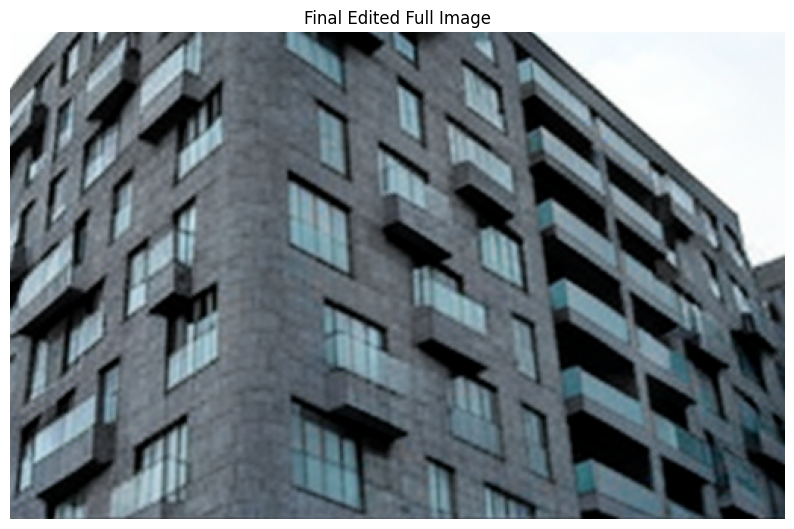

In [41]:
final_img = edit_full_image('img_001_SRF_2_LR.png', patch_size=256)


(512, 322)


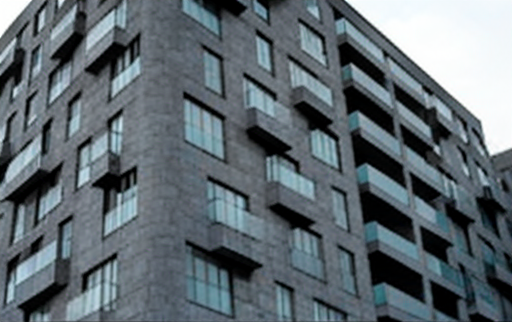

In [44]:
from PIL import Image

# Convert NumPy array back to PIL image
img_to_save = Image.fromarray(final_img)
print(img_to_save.size)

img_to_save

In [ ]:
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim
from PIL import Image

def run_sr_experiment(data_root, output_root, patch_size=256):
    """
    Run zero-shot SR experiments on all datasets and calculate mean PSNR and SSIM.
    
    Args:
        data_root (str): Root path containing BSD100, Set14, Urban100 folders.
        output_root (str): Path to save generated images.
        patch_size (int): Patch size for edit_full_image function.
    
    Returns:
        results (dict): Mean PSNR and SSIM for each dataset.
    """
    # datasets = ['BSD100', 'Set14', 'Urban100']
    datasets = ['Set14']
    results = {}

    for dataset in datasets:
        dataset_path = os.path.join(data_root, dataset)
        save_dataset_path = os.path.join(output_root, dataset)
        os.makedirs(save_dataset_path, exist_ok=True)

        psnr_list = []
        ssim_list = []

        for subfolder in os.listdir(dataset_path):
            subfolder_path = os.path.join(dataset_path, subfolder)
            if not os.path.isdir(subfolder_path):
                continue

            for file in os.listdir(subfolder_path):
                if file.endswith('LR.png'):
                    lr_path = os.path.join(subfolder_path, file)
                    hr_path = lr_path.replace('LR.png', 'HR.png')

                    # Load HR ground truth
                    lr_img = np.array(Image.open(lr_path))
                    hr_img = np.array(Image.open(hr_path))


                    # Generate image
                    final_img = edit_full_image(lr_path, patch_size=patch_size)
                    final_img_uint8 = np.clip(final_img, 0, 255).astype(np.uint8)

                    # Save generated image
                    save_path = os.path.join(save_dataset_path, file.replace('LR', 'Generated'))
                    Image.fromarray(final_img_uint8).save(save_path)

                    # # Ensure images are the same size for PSNR/SSIM calculation
                    # h, w = min(hr_img.shape[0], final_img.shape[0]), min(hr_img.shape[1], final_img.shape[1])
                    # hr_cropped = hr_img[:h, :w]
                    # final_cropped = final_img[:h, :w]
                    final_resized = np.array(
                        Image.fromarray(final_img).resize(
                            (hr_img.shape[1], hr_img.shape[0]),  # (width, height)
                            resample=Image.BICUBIC
                        )
                    )

                    # Calculate PSNR and SSIM
                    psnr = compare_psnr(hr_img, final_resized, data_range=255)
                    # ssim = compare_ssim(hr_img, final_resized, multichannel=True, data_range=255)
                    ssim = compare_ssim(hr_img, final_resized, data_range=255, channel_axis=-1, win_size=7)

                    psnr_list.append(psnr)
                    ssim_list.append(ssim)

                    print(f"[{dataset}] Processed {file} - PSNR: {psnr:.2f}, SSIM: {ssim:.4f}")

        # Calculate mean PSNR and SSIM
        mean_psnr = np.mean(psnr_list)
        mean_ssim = np.mean(ssim_list)
        results[dataset] = {
            'Mean PSNR': mean_psnr,
            'Mean SSIM': mean_ssim
        }

        print(f"\n[{dataset}] Mean PSNR: {mean_psnr:.2f}, Mean SSIM: {mean_ssim:.4f}\n")

    return results


In [ ]:
data_root = 'data'       
output_root = 'results'   # generated images

experiment_results = run_sr_experiment(data_root, output_root, patch_size=256)

print("Final Results:")
for dataset, metrics in experiment_results.items():
    print(f"{dataset} - PSNR: {metrics['Mean PSNR']:.2f}, SSIM: {metrics['Mean SSIM']:.4f}")


LR image shape: (256, 256, 3)
HR image shape: (512, 512, 3)
Generated image shape: (512, 512, 3)
Saving generated image to results/Set14/img_010_SRF_2_Generated.png
Resized generated image shape: (512, 512, 3)
[Set14] Processed img_010_SRF_2_LR.png - PSNR: 20.24, SSIM: 0.5767
LR image shape: (288, 360, 3)
HR image shape: (576, 720, 3)
Generated image shape: (576, 720, 3)
Saving generated image to results/Set14/img_002_SRF_2_Generated.png
Resized generated image shape: (576, 720, 3)
[Set14] Processed img_002_SRF_2_LR.png - PSNR: 19.74, SSIM: 0.6319
LR image shape: (180, 125, 3)
HR image shape: (360, 250, 3)
Generated image shape: (360, 250, 3)
Saving generated image to results/Set14/img_005_SRF_2_Generated.png
Resized generated image shape: (360, 250, 3)
[Set14] Processed img_005_SRF_2_LR.png - PSNR: 15.60, SSIM: 0.4402
LR image shape: (144, 176, 3)
HR image shape: (288, 352, 3)
Generated image shape: (288, 352, 3)
Saving generated image to results/Set14/img_004_SRF_2_Generated.png
Resi